In [ ]:
# Getting dataset from kaggle
%pip install opendatasets
import opendatasets as od
od.download("https://www.kaggle.com/datasets/grassknoted/asl-alphabet/")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: l
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/grassknoted/asl-alphabet


100%|██████████| 1.03G/1.03G [00:05<00:00, 203MB/s]


In [3]:
import tensorflow as tf
import os
import shutil

In [4]:
# Finds all available GPUs and enables memory growth on all of them
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu,True)

In [5]:
import numpy as np
from matplotlib import pyplot as plt

In [6]:
# Creates folders for the test images in the directory
test_dir = 'asl-alphabet/asl_alphabet_test/asl_alphabet_test'

for filename in os.listdir(test_dir):
    file_path = os.path.join(test_dir, filename)

    if os.path.isfile(file_path):

        class_name = filename.split("_")[0]  # "A_test.jpg" -> "A"
        class_folder = os.path.join(test_dir, class_name)

        if not os.path.exists(class_folder):
            os.makedirs(class_folder)

        shutil.move(file_path, os.path.join(class_folder, filename))


In [7]:
# Gets training data
train = tf.keras.utils.image_dataset_from_directory(
    'asl-alphabet/asl_alphabet_train/asl_alphabet_train',
    image_size=(64, 64),
    batch_size=128, # processes 128 images at a time
    validation_split=0.3, # saves 30% for validation
    subset="training",

    seed=123,
)
# Gets validation and testing data
val_test = tf.keras.utils.image_dataset_from_directory(
    'asl-alphabet/asl_alphabet_train/asl_alphabet_train',
    image_size=(64, 64),
    batch_size=128,
    validation_split=0.3, # gets the saved 30%
    subset="validation",
    seed=123,
)

# Gets number of batches in val_test
val_test_batches = tf.data.experimental.cardinality(val_test)

# Splits 20% to validation and 10% to testing
val = val_test.take(val_test_batches * 2 // 3)
test = val_test.skip(val_test_batches * 2 // 3)


Found 87000 files belonging to 29 classes.
Using 60900 files for training.
Found 87000 files belonging to 29 classes.
Using 26100 files for validation.



* 0 - A , 25 - Z
* 26 - del
* 27 - nothing
* 28 - space

The training set is the data used to teach the model and learn the parameters (weights and biases). The Adam optimizer updates the weight and biases to minimize loss. The validation set is the data used to help monitor model performance during training. It detects overfitting (if the accuracy is high but the validation accuracy is low), helps tune hyperparameters, and allows us to stop training early if the validation loss does not improve. The test set is also a different dataset, which is used to measure the final performance of the model.

In [8]:
class_names = train.class_names
print(class_names)
print(len(class_names))

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']
29


In [9]:
# Allows data to be saved in the RAM between epochs and allows the next batch to be prepared while current epoch is running
train = train.cache().prefetch(tf.data.AUTOTUNE)
val = val.cache().prefetch(tf.data.AUTOTUNE)
test = test.cache().prefetch(tf.data.AUTOTUNE)

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Rescaling
from tensorflow.keras import layers

In [11]:
# Adding data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.08),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
], name="data_augmentation")

In [12]:
# Creates new Sequential neural network
model = Sequential()

model.add(Rescaling(1./255, input_shape=(64, 64, 3))) # normalizes image colors from [0,255] to [0,1]
model.add(data_augmentation) # Adding data augmentation to the model
model.add(Conv2D(16, (3,3), activation='relu')) # applies 16 kernels of size 3x3 pixels to the image, relu allows model to learn complex patterns
model.add(MaxPooling2D()) # Reduces width of feature maps (halves them) while keeping important features
model.add(Conv2D(32, (3,3), activation='relu')) # applies 32 kernels to learn more complex features/patterns
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), activation='relu')) # applies 16 more kernels to learn more refined features
model.add(MaxPooling2D())
model.add(Flatten()) # Converts 2D feature maps into 1D vectors, Dense needs 1D vector
model.add(Dense(256, activation='relu')) # connects 256 neurons to all inputs of previous layer, allows the model to learn complex combintions of the features from the Conv2D layers
model.add(layers.Dropout(0.5)) # Dropout layer to prevent overfitting
model.add(Dense(29, activation='softmax')) # 29 neurons for each class, softmax makes probabilities of all classes sum to 1, highest = prediction

/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


A Sequential neural netork means that it will have 1 input and 1 output only. It also means that the data will pass throught the layers one after another. Usually used for simple CNNs.

Input: Image with shape 64x64x3 --> 64x64 pixel image, 3 color channels (r,g,b) <br>
Output: 29-class softmax

*   Rescaling: Used to normalize values to make training faster and stable
*   Conv2D: Allows the model to learn features of the images (1st is for basic, 2nd is for complex, 3rd is for refined features). Increasing the filters for the 2nd allows the model to learn more patterns. 3rd reduces to prevent overfitting
*   MaxPooling2D: Used to reduce the size of the feature maps, allowing the model to only keep important features, each one removes even more less important features
*   Flatten: Converts the 2D feature maps from Conv2D into 1D vectors for Dense to use
*   Dense: Used to learn high level patterns (1st is to learn all high level patterns, 2nd is to output probabilites for each of the 29 classes)
*   Softmax: Makes sure that probabilites from Dense sum to 1
*   ReLU: Allows the model to learn complex, non-linear patterns





In [13]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Neural networks learn by adjusting weights to minimize the loss function. The optimizer determines how the weights are updated. Adam stands for Adaptive Moment Estimation. It is used because it is good out-of-the-box; has an adaptive learning rate, meaning that it can change weights based on the history; and has less of a need to manually tune learning rates.

 A loss function measures how far the model's predictions are from the true labels. During training, the optimizer minimizes the loss by adjusting the weights. Crossentropy measures the difference between the true labels and the predicted probabilities. Multi-class classification uses crossentropy because it penalizes wrong predictions more when the model is confident about them. Sparse is used because the true labels are integers and not hot vectors. The labels are ints from 0 to 28.

In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 62, 62, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 29)             │         7,453 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 164,877 (644.05 KB)

 Trainable params: 164,877 (644.05 KB)

 Non-trainable params: 0 (0.00 B)

Parameters are learned by the model during training. They determine how the model maps inputs to outputs. Examples of these are the weights and biases of the Conv2D filters. These are basically learned by the model and not set manually. Hyperparameters are things that are set before training to control how the model learns. Example of this are batch size, learning rate, the number of filters in the Conv2D layer, the kernal size, the neurons in the Dense layer, and even the number of epochs.

In [15]:
history = model.fit(train, epochs=10, validation_data=val)

Epoch 1/10
476/476 ━━━━━━━━━━━━━━━━━━━━ 49s 77ms/step - accuracy: 0.1322 - loss: 3.0113 - val_accuracy: 0.5045 - val_loss: 1.6452
Epoch 2/10
476/476 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.4162 - loss: 1.8156 - val_accuracy: 0.6645 - val_loss: 1.0670
Epoch 3/10
476/476 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.5339 - loss: 1.4075 - val_accuracy: 0.7205 - val_loss: 0.8538
Epoch 4/10
476/476 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.6002 - loss: 1.1963 - val_accuracy: 0.7739 - val_loss: 0.6889
Epoch 5/10
476/476 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6442 - loss: 1.0449 - val_accuracy: 0.7923 - val_loss: 0.6273
Epoch 6/10
476/476 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6707 - loss: 0.9546 - val_accuracy: 0.8328 - val_loss: 0.5284
Epoch 7/10
476/476 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.6998 - loss: 0.8760 - val_accuracy: 0.8400 - val_loss: 0.4941
Epoch 8/10
476/476 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.7197 - loss: 0.8082 - val_acc

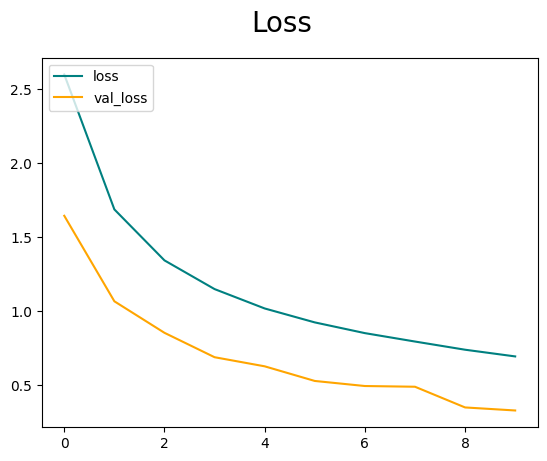

In [16]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

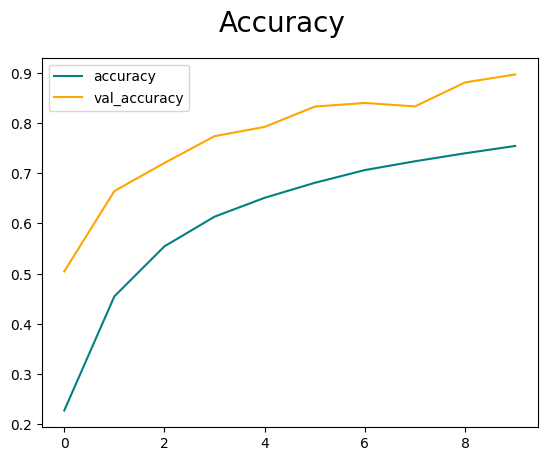

In [17]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [18]:
y_probs = model.predict(test) # contains probabilites for each class

68/68 ━━━━━━━━━━━━━━━━━━━━ 14s 105ms/step


In [19]:
import numpy as np

y_pred = np.argmax(y_probs, axis=1) # picks the index of the highest probability, converts to 1D array of ints

In [20]:
y_true = np.concatenate([y for x, y in test], axis=0) # a 1D array of labels, same shape as y_pred

In [21]:
predicted_letters = [class_names[i] for i in y_pred]
true_letters = [class_names[i] for i in y_true]

In [22]:
test_images = []
test_labels = []

for images, labels in test:
    test_images.append(images.numpy())
    test_labels.append(labels.numpy())

test_images = np.concatenate(test_images)
test_labels = np.concatenate(test_labels)

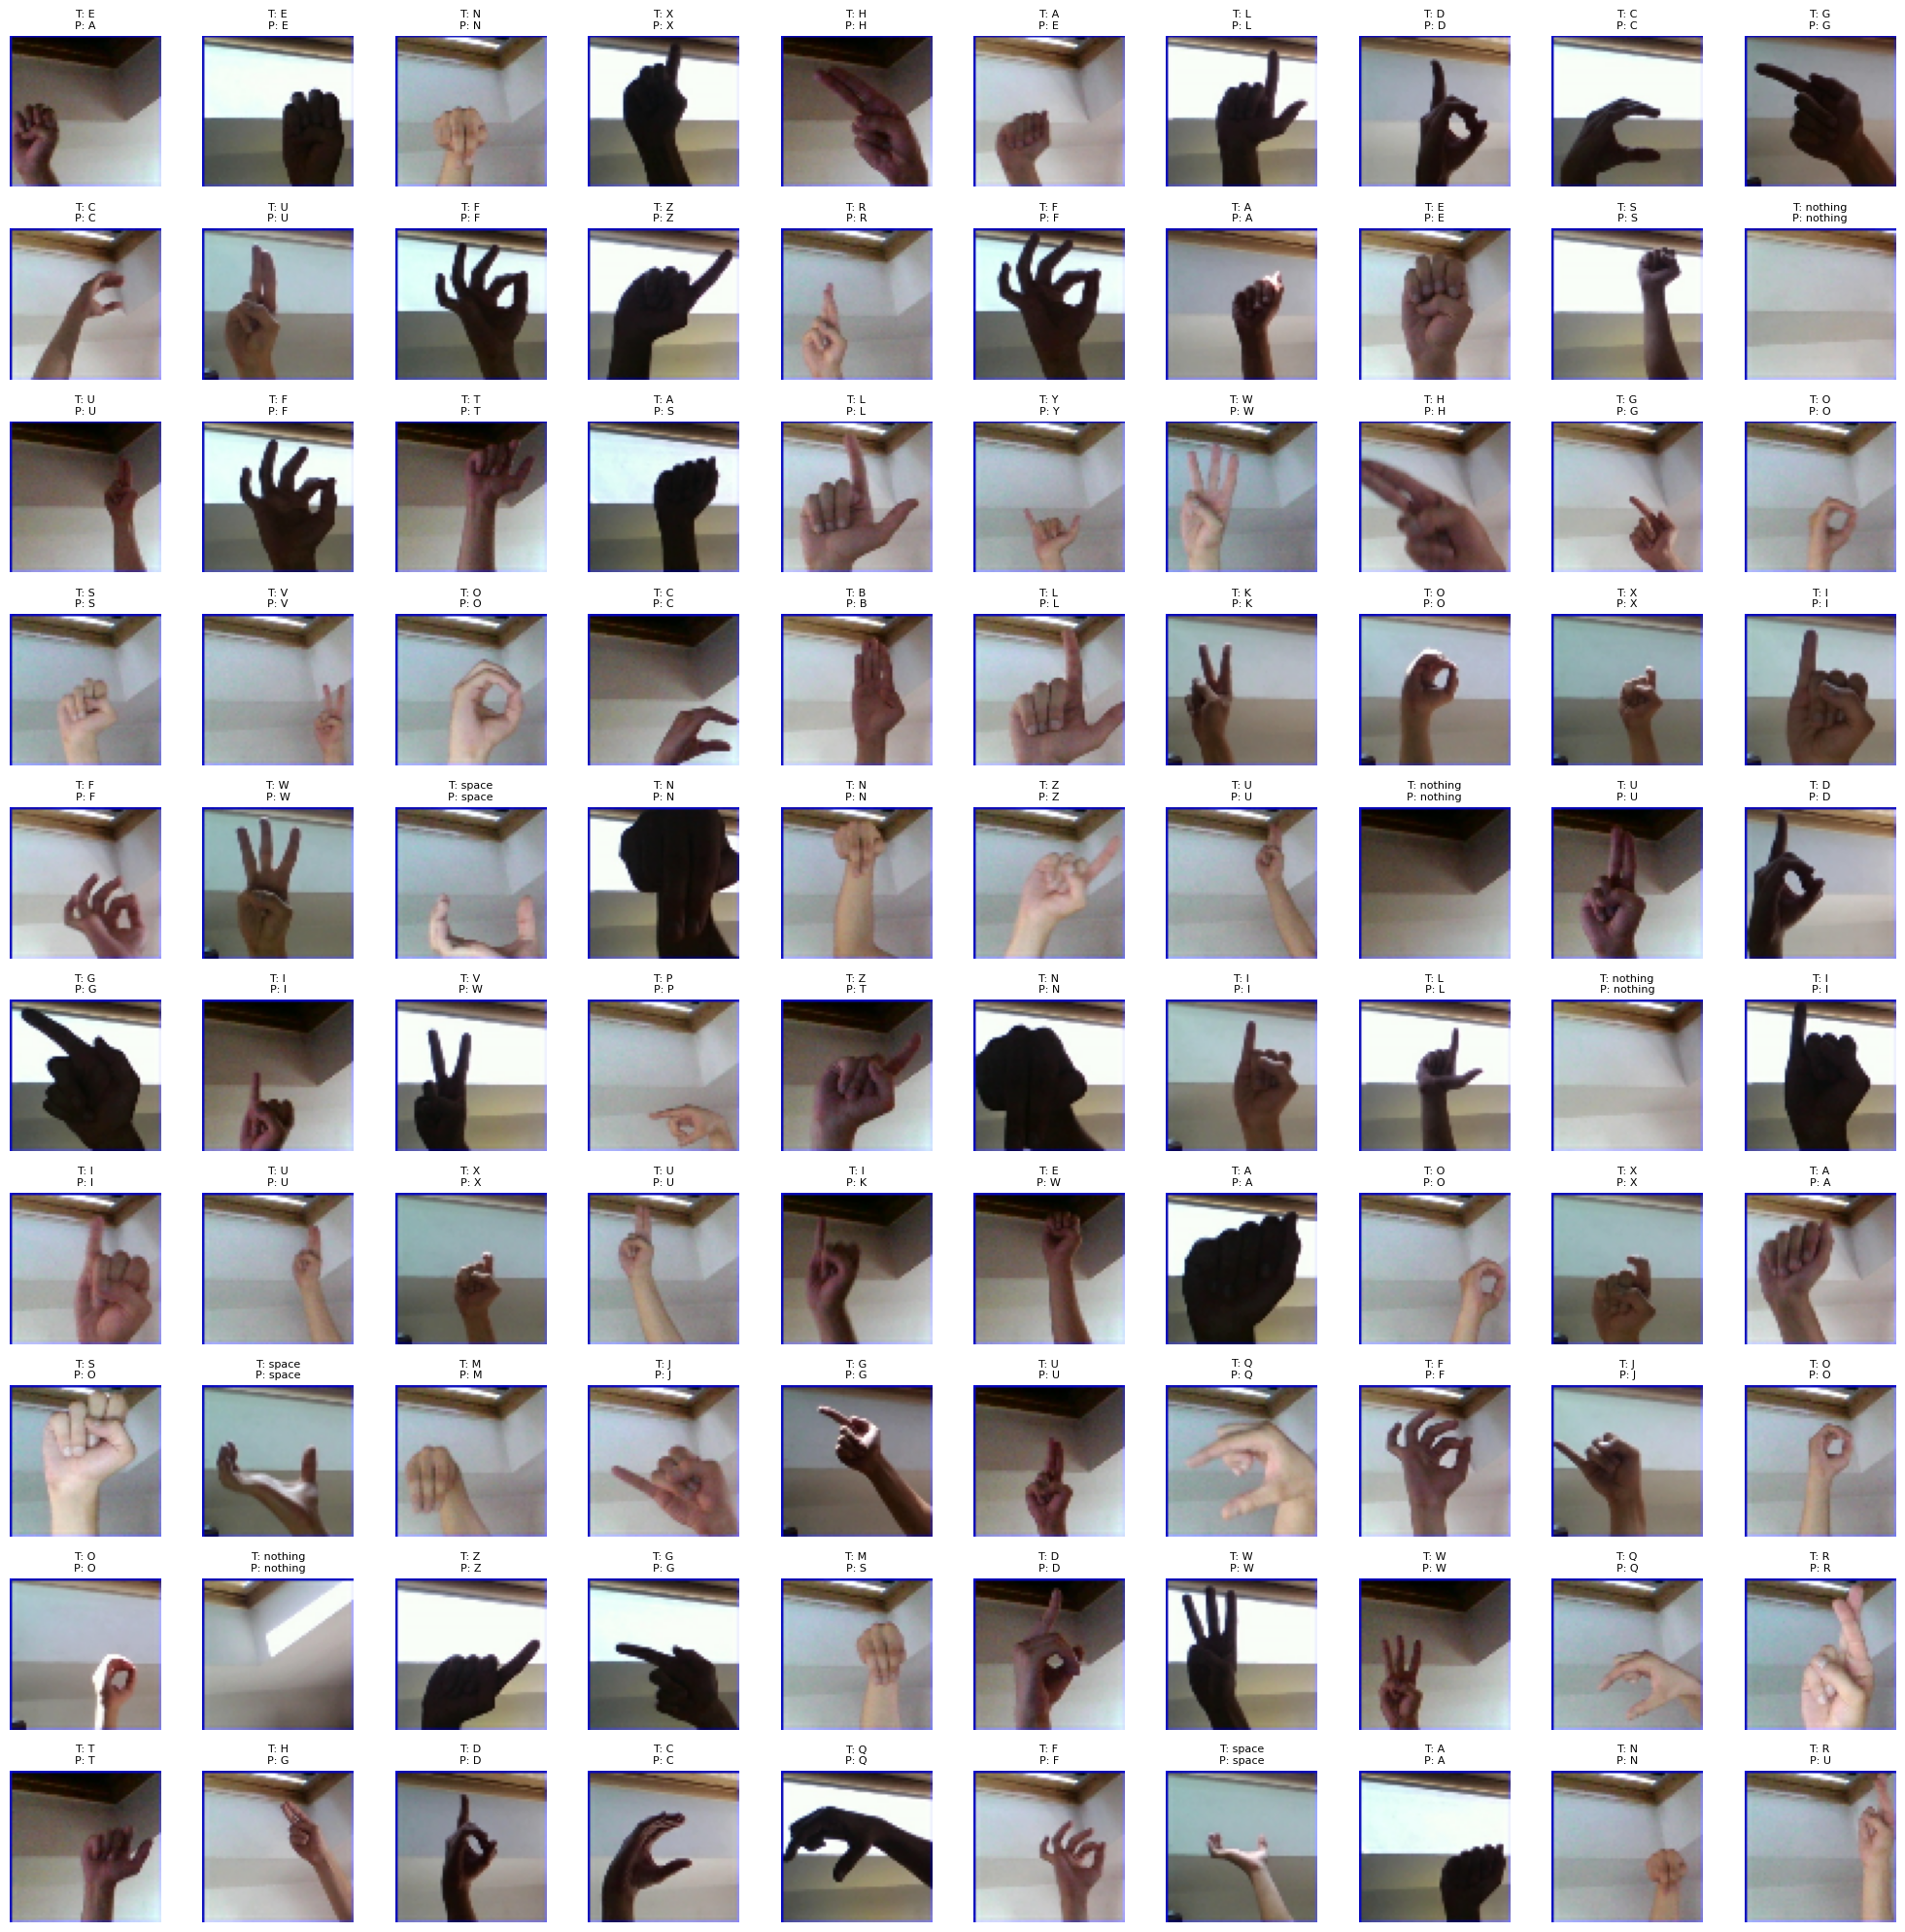

In [23]:
import math
import random

test_images_full = []
test_labels_full = []

for images, labels in test:
    test_images_full.append(images.numpy())
    test_labels_full.append(labels.numpy())

test_images_full = np.concatenate(test_images_full)
test_labels_full = np.concatenate(test_labels_full)

# Get full lists of true and predicted letters
true_letters_full = [class_names[i] for i in test_labels_full]
predicted_letters_full = [class_names[i] for i in y_pred] # y_pred is already calculated for all test data

# Randomly sample 100 images if there are more than 100
num_to_display = min(100, len(test_images_full))
sampled_indices = random.sample(range(len(test_images_full)), num_to_display)

test_images = test_images_full[sampled_indices]
true_letters = [true_letters_full[i] for i in sampled_indices]
predicted_letters = [predicted_letters_full[i] for i in sampled_indices]

num_images = len(test_images)   # number of images to display
cols = 10                        # choose how many columns you want
rows = math.ceil(num_images / cols)

plt.figure(figsize=(cols * 2, rows * 2))

for i in range(num_images):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(test_images[i].astype("uint8"))
    plt.title(f"T: {true_letters[i]}\nP: {predicted_letters[i]}", fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [24]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=class_names)) # prints per class stats

              precision    recall  f1-score   support

           A       0.76      0.82      0.79       323
           B       0.95      0.92      0.94       300
           C       0.96      1.00      0.98       286
           D       0.97      0.97      0.97       317
           E       0.82      0.81      0.82       279
           F       0.91      0.98      0.94       310
           G       0.89      0.95      0.92       310
           H       0.99      0.88      0.93       313
           I       0.98      0.90      0.94       289
           J       0.98      0.95      0.97       294
           K       0.89      0.92      0.91       289
           L       0.94      1.00      0.97       285
           M       0.94      0.70      0.80       288
           N       0.88      0.91      0.89       319
           O       0.91      0.95      0.93       291
           P       0.92      0.96      0.94       273
           Q       0.94      0.99      0.96       329
           R       0.94    

In [25]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred) # makes confusion matrix

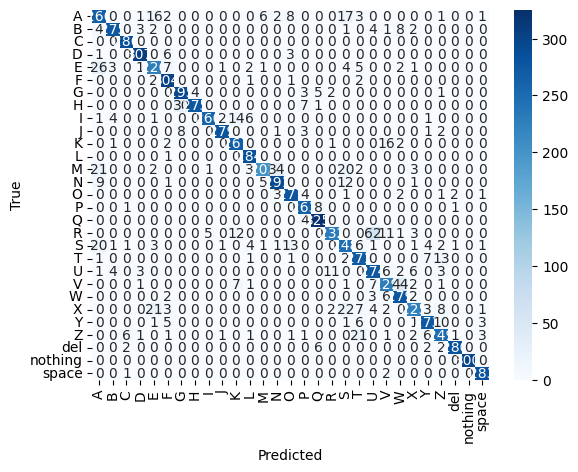

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# displays confusion matrix in a presentable manner
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [27]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

# Convert labels to one-hot (OvR)
y_true_bin = label_binarize(y_true, classes=range(29))
# y_true_bin = tf.keras.utils.to_categorical(y_true, num_classes=29)

auc_ovr = roc_auc_score(y_true_bin, y_probs, multi_class="ovr")

print("AUC-ROC (OvR):", auc_ovr)

AUC-ROC (OvR): 0.9981002327092937


In [28]:
auc_per_class = roc_auc_score(
    y_true_bin, y_probs, multi_class="ovr", average=None
)

for i, cls in enumerate(class_names):
    print(f"{cls}: AUC={auc_per_class[i]:.3f}")

A: AUC=0.995
B: AUC=0.999
C: AUC=1.000
D: AUC=1.000
E: AUC=0.996
F: AUC=0.999
G: AUC=0.999
H: AUC=1.000
I: AUC=1.000
J: AUC=1.000
K: AUC=0.999
L: AUC=1.000
M: AUC=0.994
N: AUC=0.998
O: AUC=0.999
P: AUC=1.000
Q: AUC=1.000
R: AUC=0.996
S: AUC=0.992
T: AUC=0.998
U: AUC=0.996
V: AUC=0.995
W: AUC=0.998
X: AUC=0.996
Y: AUC=0.999
Z: AUC=0.997
del: AUC=1.000
nothing: AUC=1.000
space: AUC=1.000


In [ ]:
# Converting to TFLite model for mobile deployment

# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]

# tflite_model = converter.convert()

# with open("asl_model.tflite", "wb") as f:
#     f.write(tflite_model)

# from google.colab import files
# files.download("asl_model.tflite")

Saved artifact at '/tmp/tmpgu2xevov'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 29), dtype=tf.float32, name=None)
Captures:
  134288317591248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134288317592016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134288317589904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134288317586256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134288317591824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134288317592208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134288317593168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134288317593360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134288317593744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134288317592784: TensorSpec(shape=(), dtype=tf.resource, name=None)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>